In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
import random


import os, sys
sys.path.insert(0,'..')

from collections import deque 

from dfibert.tracker.nn.rl import Agent, DQN
import dfibert.envs.RLtractEnvironment as RLTe
from dfibert.cache import save_vtk_streamlines

from dfibert.envs._state import TractographyState

import matplotlib.pyplot as plt
%matplotlib notebook

#from train import load_model

In [3]:
import importlib
importlib.reload(RLTe)

<module 'dfibert.envs.RLtractEnvironment' from '../dfibert/envs/RLtractEnvironment.py'>

In [2]:
env = RLTe.RLtractEnvironment(stepWidth=0.8, action_space=100, device = 'cpu', 
                              pReferenceStreamlines='/bigdata/hplsim/aipp/RLtract/deepFibreTracking/examples/data/dti_ijk_0.8_maxDirecGetter.vtk', 
                              tracking_in_RAS = False, odf_state = False)
n_actions = env.action_space.n

Loading precomputed streamlines (/bigdata/hplsim/aipp/RLtract/deepFibreTracking/examples/data/dti_ijk_0.8_maxDirecGetter.vtk) for ID 100307
sphere_odf = sphere_action = repulsion100
Computing ODF
Computing pmf


In [3]:
import dipy.reconst.dti as dti
dti_model = dti.TensorModel(env.dataset.data.gtab, fit_method='LS')
dti_fit = dti_model.fit(env.dataset.data.dwi, mask=env.dataset.data.binarymask)

# compute ODF
odf = dti_fit.odf(env.sphere_odf)
pmf = odf.clip(min=0)

In [4]:
print(pmf.shape)

(145, 174, 145, 100)


In [8]:
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
pmf_cur = env.pmf_gen.get_pmf(state.getCoordinate().double().squeeze(0).numpy())
reward = pmf_cur / np.max(pmf_cur)
print(np.argmax(reward))

93


In [3]:
terminal = False
all_states = []
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
current_direction = None
while not terminal:
    my_position = state.getCoordinate().double().squeeze(0).numpy()
    all_states.append(my_position)
    
    action = env._get_best_action(current_direction, my_position)
    state, reward, terminal, _  = env.step(action)
    
    
%matplotlib notebook
states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(states.T[0], states.T[1], states.T[2])
plt.legend(['gt', 'agent'])

action shape:  ()
cur_tangent:  tensor([ 0.8961, -0.3757, -0.2365], dtype=torch.float64)
cur_tangent after correction:  tensor([[ 0.8961, -0.3757, -0.2365]], dtype=torch.float64)
next_position in step:  tensor([[24.5447, 77.4656, 50.3005]], dtype=torch.float64)
action shape:  ()
cur_tangent:  tensor([ 0.8961, -0.3757, -0.2365], dtype=torch.float64)


ValueError: shapes (3,) and (1,3) not aligned: 3 (dim 0) != 1 (dim 0)

In [3]:
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)

In [5]:
from dipy.direction import DeterministicMaximumDirectionGetter
dg = DeterministicMaximumDirectionGetter.from_pmf(pmf=pmf, max_angle=30, sphere=env.sphere_odf)

In [7]:
direction = dg.initial_direction(state.getCoordinate().double().numpy())
action = np.where(env.sphere.vertices == direction)[0][0]
print(action)

93


ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [16]:
print(action.shape)

(1, 3)


### Load pretrained agent and analyse its behaviour

In [3]:
streamline_index = 1
device = "cpu"
max_steps = 30000000
replay_memory_size = 100000
agent_history_length = 1
evaluate_every = 200000
eval_runs = 5#20
network_update_every = 10000
start_learning = 10000
eps_annealing_steps = 400000

max_episode_length = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 512
learning_rate = 0.000001 


state = env.reset(streamline_index=streamline_index, start_index=-2, start_middle_of_streamline=False)
env.referenceStreamline_ijk, state.getCoordinate()

(tensor([[23.8278, 77.7661, 50.4897],
         [24.5447, 77.4656, 50.3005],
         [25.2732, 77.4055, 49.9754],
         [25.5940, 77.9652, 49.5023],
         [25.9148, 78.5249, 49.0293],
         [26.4700, 78.9807, 48.6771],
         [27.0251, 79.4365, 48.3248],
         [26.6042, 79.8737, 47.8037],
         [26.0320, 80.0483, 47.2726],
         [25.4597, 80.2229, 46.7414],
         [24.8875, 80.3975, 46.2103],
         [24.2499, 80.7637, 45.8952],
         [23.6123, 81.1300, 45.5801],
         [22.8479, 81.3547, 45.5077],
         [22.1310, 81.6552, 45.6968],
         [21.4142, 81.9557, 45.8860],
         [21.0027, 82.6414, 45.9119],
         [20.2743, 82.7014, 46.2370],
         [19.7169, 82.6995, 46.8108],
         [19.0000, 83.0000, 47.0000]]),
 tensor([19.7169, 82.6995, 46.8108]))

In [5]:
# this agent got DWI input data and then predicts the direction out of 20 possible actions
# reward: odf20
model, step_counter, mean_reward, epsilon = load_model('defi_2.86_dwi_odf100.pt')

#model, step_counter, mean_reward, epsilon = load_model('defi_4.95_dwi_odf20.pt')
agent = Agent(n_actions=20, inp_size=state.getValue().shape, device=device, hidden=10, gamma=0.99, 
              agent_history_length=agent_history_length, 
              memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

agent.main_dqn.load_state_dict(model)
agent.target_dqn.load_state_dict(model)

Loading checkpoint from defi_2.86_dwi_odf100.pt


<All keys matched successfully>

In [6]:
if(False):
    # this agent got ODF input data and then predicts the direction out of 100 possible actions
    # reward: odf20
    model, step_counter, mean_reward, epsilon = load_model('defi_4.81_odf20state_odf20.pt')
    agent = Agent(n_actions=20, inp_size=state.getValue().shape, device=device, hidden=10, gamma=0.99, 
                  agent_history_length=agent_history_length, 
                  memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

    agent.main_dqn.load_state_dict(model)
    agent.target_dqn.load_state_dict(model)

In [4]:
agent = Agent(n_actions=100, inp_size=state.getValue().shape, device=device, hidden=10, gamma=0.99, 
              agent_history_length=agent_history_length, 
              memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

In [25]:
odf_peaks = torch.mean(torch.from_numpy(env.interpolateODFatState(stateCoordinates=my_position)), dim=1)
print(odf_peaks)

tensor([[[0.0702, 0.0538, 0.0764],
         [0.0715, 0.0613, 0.0742],
         [0.0530, 0.0675, 0.0631]],

        [[0.0703, 0.0548, 0.0784],
         [0.0728, 0.0663, 0.0811],
         [0.0551, 0.0735, 0.0715]],

        [[0.0712, 0.0569, 0.0789],
         [0.0728, 0.0662, 0.0803],
         [0.0543, 0.0687, 0.0602]],

        [[0.0696, 0.0517, 0.0750],
         [0.0714, 0.0597, 0.0722],
         [0.0539, 0.0701, 0.0705]],

        [[0.0725, 0.0606, 0.0819],
         [0.0756, 0.0744, 0.0879],
         [0.0579, 0.0761, 0.0677]],

        [[0.0721, 0.0581, 0.0774],
         [0.0735, 0.0651, 0.0745],
         [0.0546, 0.0664, 0.0582]],

        [[0.0700, 0.0537, 0.0772],
         [0.0736, 0.0669, 0.0791],
         [0.0577, 0.0773, 0.0795]],

        [[0.0731, 0.0615, 0.0809],
         [0.0752, 0.0719, 0.0824],
         [0.0571, 0.0712, 0.0581]],

        [[0.0715, 0.0554, 0.0754],
         [0.0727, 0.0608, 0.0695],
         [0.0540, 0.0665, 0.0622]],

        [[0.0722, 0.0601, 0.0820],
  

In [16]:
odf_peaks = torch.from_numpy(env.interpolateODFatState(stateCoordinates=my_position))
similarities = torch.nn.functional.cosine_similarity(env.directions, odf_peaks)
print(similarities)

RuntimeError: The size of tensor a (100) must match the size of tensor b (3) at non-singleton dimension 2

odf_cur:  tensor([0.0457, 0.0467, 0.0463, 0.0459, 0.0491, 0.0457, 0.0470, 0.0470, 0.0455,
        0.0483, 0.0479, 0.0461, 0.0484, 0.0461, 0.0485, 0.0466, 0.0457, 0.0495,
        0.0463, 0.0471, 0.0473, 0.0461, 0.0510, 0.0466, 0.0461, 0.0495, 0.0472,
        0.0482, 0.0471, 0.0461, 0.0507, 0.0474, 0.0466, 0.0482, 0.0472, 0.0500,
        0.0468, 0.0468, 0.0492, 0.0609, 0.0472, 0.0474, 0.0473, 0.0938, 0.0471,
        0.0466, 0.0483, 0.0489, 0.0481, 0.0468, 0.0457, 0.0467, 0.0463, 0.0459,
        0.0491, 0.0457, 0.0470, 0.0470, 0.0455, 0.0483, 0.0479, 0.0461, 0.0484,
        0.0461, 0.0485, 0.0466, 0.0457, 0.0495, 0.0463, 0.0471, 0.0473, 0.0461,
        0.0510, 0.0466, 0.0461, 0.0495, 0.0472, 0.0482, 0.0471, 0.0461, 0.0507,
        0.0474, 0.0466, 0.0482, 0.0472, 0.0500, 0.0468, 0.0468, 0.0492, 0.0609,
        0.0472, 0.0474, 0.0473, 0.0938, 0.0471, 0.0466, 0.0483, 0.0489, 0.0481,
        0.0468], dtype=torch.float64)
reward:  tensor([0.4876, 0.4976, 0.4932, 0.4892, 0.5230, 0.4871, 0.5006,

<IPython.core.display.Javascript object>


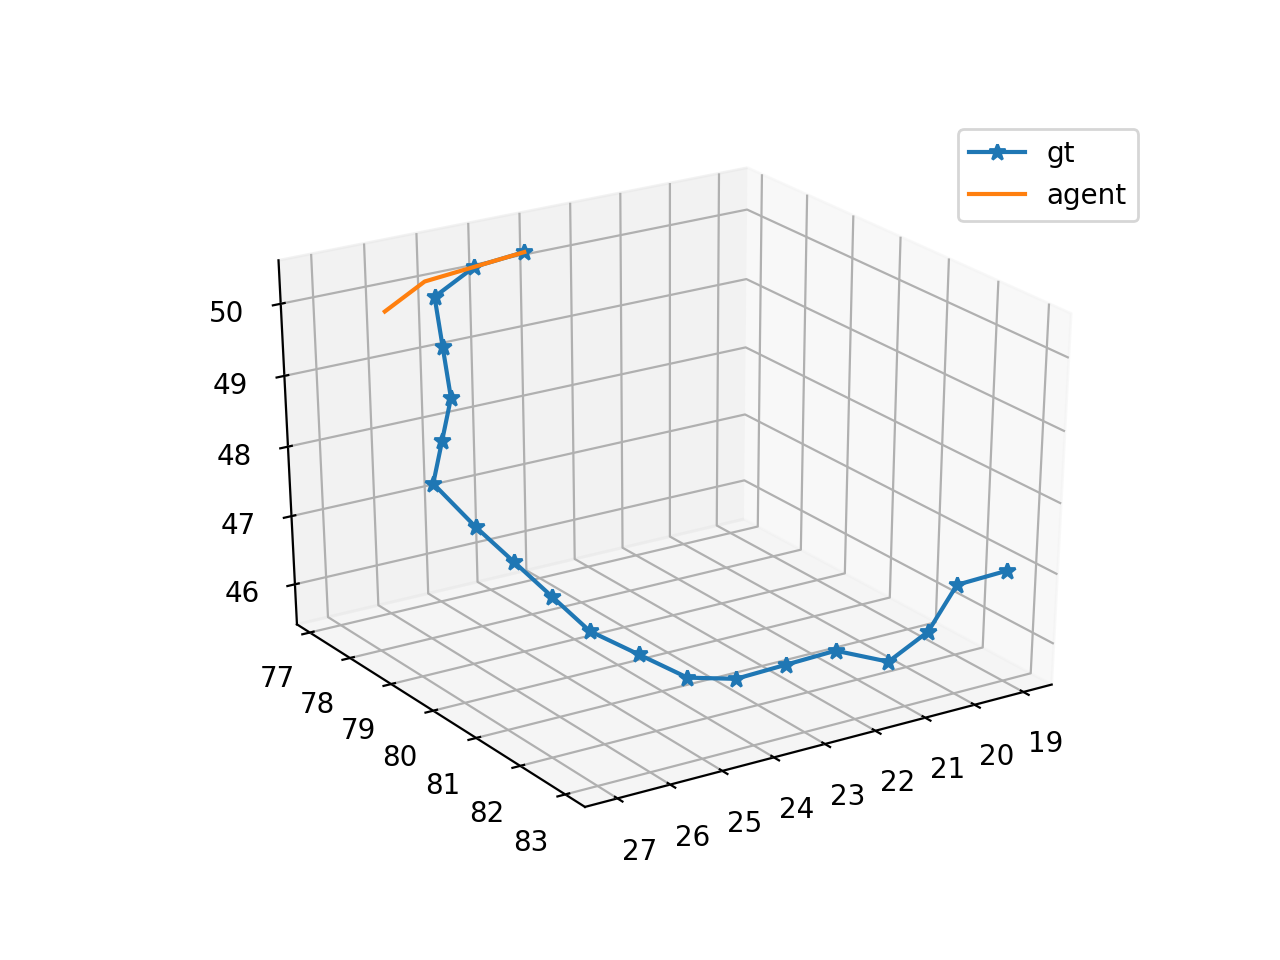

In [7]:
eval_rewards = []
all_distances = []
all_states = []
l2s = []
max_episode_length = 20
fa_threshold = 0.1
K = 3

#agent.main_dqn.eval()
for _ in range(1):
    eval_steps = 0
    state = env.reset(streamline_index=streamline_index, start_middle_of_streamline=False, start_index=0)
    next_state = state
    all_states.append(state.getCoordinate())
    eval_episode_reward = 0
    episode_final = 0
    current_direction = None
    while eval_steps < max_episode_length:
        
        #with torch.no_grad():
        #    state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
        #    action = torch.argmax(agent.main_dqn(state_v)).item()
        
        my_position = all_states[-1]
        
        
       # if(eval_steps > 0):
       #     # compute tangent of previous step
       #     current_direction = all_states[-1] - all_states[-2]
       #     current_direction = current_direction / torch.sqrt(torch.sum(current_direction**2))
       #     current_direction = current_direction.view(1,3)
       #     
       #     print(current_direction)
       #     print(env.directions[action])
       #     same ---> therefore sticking to env.directions[action]
        #current_direction = env.directions[action].view(1,3)
        
        #action = get_multi_best_action(current_direction, odf_interpolator, my_position, mysphere, sphere_verts_torch, K = K)
        action = env._get_best_action(current_direction, my_position)
        
        
        next_state, reward, terminal, _ = env.step(action)
        
        #reward = reward
        
        print(eval_steps, my_position, "=>", next_state.getCoordinate().numpy(), action, reward)

        
        all_distances.append(reward)
        all_states.append(next_state.getCoordinate().squeeze())
                
        state = next_state
        print("---")
        if terminal:
            terminal = False
            break
            
        eval_episode_reward += reward
        eval_steps += 1

    eval_rewards.append(eval_episode_reward)

print("Evaluation score:", np.min(eval_rewards))

########################
### visualise streamline
########################
%matplotlib notebook 
state = env.reset(streamline_index=streamline_index) 

states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(states.T[0], states.T[1], states.T[2])
plt.legend(['gt', 'agent'])

In [24]:
state = env.reset(streamline_index=1, start_middle_of_streamline=False, start_index=0)
all_states.append(state.getCoordinate())

peak_indices = peaks_from_model(
    model=dti_model, data=env.dataset.data.dwi, sphere=mysphere, relative_peak_threshold=.2,
    min_separation_angle=25, mask=env.dataset.data.binarymask, npeaks=2) # Peaks and Metrics object


for i in range(len(env.referenceStreamline_ijk)):
    odf = torch.from_numpy(env.interpolateODFatState(stateCoordinates=env.referenceStreamline_ijk[i]))[:,1,1,1].view(100)
    action = torch.argmax(odf)
    
    gt_direction = env.referenceStreamline_ijk[i+1] - env.referenceStreamline_ijk[i]
    gt_direction = (gt_direction / torch.sqrt(torch.sum(gt_direction**2))).view(1,3)
    
    gt_action = torch.argmax(torch.nn.functional.cosine_similarity(gt_direction, env.directions))
    
    next_state, reward, terminal, _ = env.step(action)
    all_states.append(next_state.getCoordinate().squeeze())
    
    print("Step: ", i)
    print("ODF gt: ", odf[gt_action])
    print("max ODF: ", torch.max(odf))
    print("action: ", action)
    

states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(states.T[0], states.T[1], states.T[2])
plt.legend(['gt', 'agent'])

Step:  0
ODF gt:  tensor(0.0938, dtype=torch.float64)
max ODF:  tensor(0.0938, dtype=torch.float64)
action:  tensor(93)
Step:  1
ODF gt:  tensor(0.0827, dtype=torch.float64)
max ODF:  tensor(0.1153, dtype=torch.float64)
action:  tensor(93)
Step:  2
ODF gt:  tensor(0.0887, dtype=torch.float64)
max ODF:  tensor(0.0925, dtype=torch.float64)
action:  tensor(30)
Step:  3
ODF gt:  tensor(0.1391, dtype=torch.float64)
max ODF:  tensor(0.1391, dtype=torch.float64)
action:  tensor(70)
Step:  4
ODF gt:  tensor(0.1046, dtype=torch.float64)
max ODF:  tensor(0.1064, dtype=torch.float64)
action:  tensor(70)
Step:  5
ODF gt:  tensor(0.1213, dtype=torch.float64)
max ODF:  tensor(0.1213, dtype=torch.float64)
action:  tensor(33)
Step:  6
ODF gt:  tensor(0.0437, dtype=torch.float64)
max ODF:  tensor(0.1655, dtype=torch.float64)
action:  tensor(33)
Step:  7
ODF gt:  tensor(0.0738, dtype=torch.float64)
max ODF:  tensor(0.5357, dtype=torch.float64)
action:  tensor(18)
Step:  8
ODF gt:  tensor(0.0960, dtype=t

IndexError: index 20 is out of bounds for dimension 0 with size 20

In [22]:
gt_direction.shape

torch.Size([3])

### Debug deterministic tracking of Dipy

In [64]:
from scipy.interpolate import RegularGridInterpolator
import dipy.reconst.dti as dti

from dipy.direction import peaks_from_model
from dipy.data import get_sphere


# fit DTI model to data
dti_model = dti.TensorModel(env.dataset.data.gtab, fit_method='LS')
dti_fit = dti_model.fit(env.dataset.data.dwi, mask=env.dataset.data.binarymask)

#TODO: Issue => are we using the correct data for tractography actually??? The data got 288 gradient directions
# seems like its using the data of all bvals!!!
mysphere = get_sphere('repulsion100')
odf = dti_fit.odf(mysphere)

## set up interpolator for directions
x_range = np.arange(odf.shape[0])
y_range = np.arange(odf.shape[1])
z_range = np.arange(odf.shape[2])



#affine = env.dataset.data.aff # tracking in RAS
affine = np.eye(4) # tracking in IJK

In [26]:
dti_fit.shm_coeff

AttributeError: 'TensorFit' object has no attribute 'shm_coeff'

In [ ]:
#dir_interpolator = RegularGridInterpolator((x_range,y_range,z_range), dir)
odf_interpolator = RegularGridInterpolator((x_range,y_range,z_range), odf)
fa_interpolator = RegularGridInterpolator((x_range,y_range,z_range), dti_fit.fa)
#pd_interpolator = RegularGridInterpolator((x_range,y_range,z_range), peak_indices.peak_dirs)

In [ ]:
env.dataset.get_fa

In [ ]:
peak_indices = peaks_from_model(
    model=dti_model, data=env.dataset.data.dwi, sphere=mysphere, relative_peak_threshold=.2,
    min_separation_angle=25, mask=env.dataset.data.binarymask, npeaks=2, parallel=True) # Peaks and Metrics object

In [ ]:
import dipy
dg = dipy.direction.DeterministicMaximumDirectionGetter.from_shcoeff(peak_indices.shm_coeff, 80, peak_indices.sphere)

In [ ]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
fa_img = dti_fit.fa
fa_img[np.isnan(fa_img)] = 0
stopping_criterion = ThresholdStoppingCriterion(fa_img, .1)

In [ ]:
from dipy.tracking import utils

seed_mask = fa_img.copy()
seed_mask[seed_mask >= 0.2] = 1
seed_mask[seed_mask < 0.2] = 0

seeds = utils.seeds_from_mask(seed_mask, affine=np.eye(4), density=1) # tracking in IJK

In [ ]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialize local tracking - computation happens in the next step. 
# EuDX, https://dipy.org/documentation/1.0.0./examples_built/tracking_introduction_eudx/#garyfallidis12
# EuDx => change dg into pam
streamlines_generator = LocalTracking(
    dg, stopping_criterion, seeds, affine=np.eye(4), step_size=.8) # tracking in IJK

# Generate streamlines object
streamlines = Streamlines(streamlines_generator)
streamlines[0]
# tracked_streamlines = filter(lambda sl: len(sl) >= 10, tracked_streamlines)

In [ ]:
streamlines_cropped = list(filter(lambda sl: len(sl) >= 10, streamlines))
len(streamlines_cropped) / len(streamlines)

In [ ]:
save_vtk_streamlines(streamlines=streamlines_cropped, filename="dti_ijk_0.8_maxDirecGetter.vtk")

## Ground-truth direction

In [ ]:
cool_sl = 2
idx = 4
ref_sl = env.referenceStreamline_ijk

In [ ]:
diff_vector = (ref_sl[idx+1] - ref_sl[idx])
diff_vector_norm = diff_vector / torch.sqrt(torch.sum(diff_vector**2))
"gt", diff_vector_norm

In [ ]:
#pv_norm = pd_interpolator(ref_sl[idx+1]) / np.sqrt(np.sum((pd_interpolator(ref_sl[idx+1])**2)))

odf_max = np.argmax(odf_interpolator(ref_sl[idx]))
odf_max_norm = mysphere.vertices[odf_max]

#"pv", pv_norm, 
"odf", odf_max_norm

In [ ]:
odf_x = odf_interpolator(ref_sl[idx]).squeeze()
plt.plot(odf_x,'.')

# Debug data  generation

In [ ]:
import os, sys

import gym
from gym.spaces import Discrete, Box
import numpy as np

from dipy.data import get_sphere
from dipy.data import HemiSphere, Sphere
from dipy.core.sphere import disperse_charges
import torch


from dfibert.data.postprocessing import res100, resample
from dfibert.data import HCPDataContainer, ISMRMDataContainer, PointOutsideOfDWIError
from dfibert.tracker import StreamlinesFromFileTracker
from dfibert.util import get_grid

import shapely.geometry as geom
from shapely.ops import nearest_points
from shapely.strtree import STRtree


from collections import deque

dataset = HCPDataContainer('100307')
dataset.normalize()

In [ ]:
coord, data = next_state.getCoordinate(), next_state.getValue()
grid = get_grid(np.array([3,3,3]))
ras_points = env.dataset.to_ras(coord)
ras_points = grid + ras_points

interpolated_dwi = env.dataset.get_interpolated_dwi(ras_points, postprocessing=None)
#interpolated_dwi = np.rollaxis(interpolated_dwi,3)

dti_fit = dti_model.fit(interpolated_dwi)
mysphere = get_sphere('repulsion100')
odf = dti_fit.odf(mysphere)

In [ ]:
plt.figure()
plt.plot(range(100), np.mean(odf.reshape(-1,100), axis=0))
plt.plot(range(100), odf[1,1,1,:])

In [ ]:
interpolated_dwi.shape

In [ ]:
states, actions, _, _, _ = agent.replay_memory.get_minibatch()
states = torch.FloatTensor(states).to(agent.device)
predicted_q = torch.argmax(agent.main_dqn(states), dim=1)

false = 0
for i in range(len(actions)):
    if predicted_q[i] != actions[i]:
        false += 1 
    
print("Accuracy =", 1 - false / len(actions))

# Analysis of our environment

In [ ]:
env._get_best_action(None, my_position)

In [ ]:
gt_direction = env.referenceStreamline_ijk.T[:,-1] - env.referenceStreamline_ijk.T[:,-2]
gt_direction = gt_direction / torch.sqrt(torch.sum(gt_direction**2))
gt_direction = gt_direction.view(1,3)

gt_direction

In [ ]:
env.directions[96]

In [ ]:
my_position

In [ ]:
my_position = all_states[0]
eval_steps = 0

current_direction = None
        
if(eval_steps > 0):
    # compute tangent of previous step
    current_direction = all_states[-1] - all_states[-2]
    current_direction = current_direction / torch.sqrt(torch.sum(current_direction**2))
    current_direction = current_direction.view(1,3)

action = env._get_best_action(current_direction, my_position)
action

In [ ]:
# main peak from ODF
peak_dir = env._get_best_action_ODF(my_position)

# cosine similarity wrt. all directions
reward = abs(torch.nn.functional.cosine_similarity(peak_dir.view(1,-1), env.directions))

if(current_direction is not None):
    reward = reward * (torch.nn.functional.cosine_similarity(current_direction, env.directions))

best_action = torch.argmax(reward)
print("Max reward: %.2f" % (torch.max(reward).cpu().detach().numpy()))

In [ ]:
odf_l = torch.from_numpy(env.interpolateODFatState(stateCoordinates=my_position))[:,1,1,1].view(100)
#odf_l = torch.mean(odf_l, 1)
reward = odf_l / torch.max(odf_l)
reward = reward * (torch.nn.functional.cosine_similarity(current_direction, env.directions))
torch.argmax(odf_l), torch.argmax(reward)

In [ ]:
(torch.nn.functional.cosine_similarity(current_direction, env.directions)).shape

In [ ]:
reward.shape

In [ ]:
reward[73]

In [ ]:
fig = plt.figure()
plt.plot(reward.cpu().detach().numpy().squeeze(), '.')

In [ ]:
env.directions

In [ ]:
current_direction

In [ ]:
my_position.cpu().numpy()

In [ ]:
states.T.shape

In [ ]:
k_largest.shape

In [ ]:
np.argmax(my_odf.squeeze())

In [ ]:
all_states

In [ ]:
### visualise streamline
%matplotlib notebook 
state = env.reset(streamline_index=50) 

states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0][0:10], env.referenceStreamline_ijk.T[1][0:10], env.referenceStreamline_ijk.T[2][0:10])
ax.plot3D(states.T[0][0:10], states.T[1][0:10], states.T[2][0:10])